In [1]:
from mlagents.torch_utils import torch, default_device
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import art3d
import numpy as np
import time

from mlagents.plugins.skeleton_aware_op.dataset import TemporalMotionData, SkeletonInfo
from mlagents.plugins.skeleton_aware_op.autoencoder_temporal import StaticEncoder, AE, Encoder, Decoder
from mlagents.plugins.skeleton_aware_op.discriminator_temporal import Discriminator
from mlagents.plugins.skeleton_aware_op.loss import calc_chain_velo_loss, calc_ee_loss
from mlagents.plugins.bvh_utils import lafan_utils
from mlagents.plugins.bvh_utils import BVH_mod as BVH
from mlagents.plugins.skeleton_aware_op.options import get_options

from mlagents.plugins.bvh_utils.visualize import skeleton_plot, two_skeleton_plot, motion_animation
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default

%config Completer.use_jedi = False

# setup cuda devices
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
    
torch.device(device)

device(type='cuda', index=0)

## Hyperparameters

In [15]:
options = get_options()

# optimizer parameters
epochs = 80
learning_rate = 0.002
lr_freq = 0.15
lr_decay = 0.97
betas=(0.9, 0.999)
batch_size = 32

# loss factors
mult_ee  = 1000
mult_adv = 100
mult_glob= 1000
mult_chain_velo = 1

real_label = 1
fake_label = 0

isNormalize = True
normalize_velo = False

discrim_epoch=0
dropout = options['drop_percentage']


# limits = [[100,200],[500,600],[0,100]]
limits = [[-50,50],[-50,50],[-50,50]]

## Load Data

In [16]:
data_path = './data/LaFan/Real_Data'
sim_path = './data/LaFan/Input_Motion'
# test_path = './data/LaFan/Test'

# dataset which constitutes the real data
adv_dataset = TemporalMotionData(data_path, recalculate_mean_var = False, normalize_data = isNormalize,device=device)
# train and test input motion fed to the autoencoder
train_input_dataset = TemporalMotionData(sim_path, recalculate_mean_var = False, normalize_data = isNormalize,device=device)
test_input_dataset = TemporalMotionData(sim_path, recalculate_mean_var = False, normalize_data = isNormalize, device=device)

train_input_dataloader = torch.utils.data.DataLoader(train_input_dataset[20:700],
                                                     shuffle=True, batch_size=batch_size,
                                                     num_workers=0)
test_input_dataloader = torch.utils.data.DataLoader(train_input_dataset[700:800], 
                                                    shuffle=True, batch_size=batch_size,
                                                    num_workers=0)

[DATASET] final data shape :  torch.Size([979, 88, 16])
[DATASET] load mean var
[DATASET] final data shape :  torch.Size([979, 88, 16])
[DATASET] load mean var
[DATASET] final data shape :  torch.Size([979, 88, 16])
[DATASET] load mean var


## Skeleton and Topology preprocessing

In [17]:
skdata_data = SkeletonInfo(data_path)
skdata_sim = SkeletonInfo(sim_path)

tensor(4)
tensor(8)
tensor(13)
tensor(17)
tensor(21)
tensor(4)
tensor(8)
tensor(13)
tensor(17)
tensor(21)


In [18]:
encoder_sim = Encoder(skdata_sim.edges)
# use the initialization of encoder_data to get the correct pooling lists
# its forward is not used
encoder_data = Encoder(skdata_data.edges) 
decoder_data = Decoder(encoder_data)

static_encoder_sim = StaticEncoder(skdata_sim.edges).to(device)
static_encoder_data = StaticEncoder(skdata_data.edges).to(device)
discriminator = Discriminator(skdata_data.edges).to(device)

In [19]:
real_label = 1.0
fake_label = 0.0

# this might be the only loss we can use since we don't 
# have a direct reference to a motion
criterion_gan = torch.nn.MSELoss()
criterion_ee = torch.nn.MSELoss()
criterion_glob = torch.nn.MSELoss()
criterion_velo = torch.nn.MSELoss()

# Optimizers
# concatenate parameters used for pose generation
gen_parameters = list(encoder_sim.parameters()) + list(decoder_data.parameters()) \
    + list(static_encoder_sim.parameters()) + list(static_encoder_data.parameters())


gen_optimizer = torch.optim.Adam(gen_parameters, lr=learning_rate, betas=(0.9, 0.999))
discrim_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# scheduler = torch.optim.lr_scheduler.StepLR(gen_optimizer, 10, 0.9)
cyclic_decay = lambda x : max(0.0001,0.4*(np.cos(lr_freq*x)+1.2)*(lr_decay**x))
scheduler = torch.optim.lr_scheduler.LambdaLR(gen_optimizer, lr_lambda=cyclic_decay)

Epoch :  0
Batch : 0, Discriminator loss: 0.4842451810836792, Generator loss : 1013.126410284881
Batch : 10, Discriminator loss: 0.452140212059021, Generator loss : 840.5650375173193
Batch : 20, Discriminator loss: 0.48137515783309937, Generator loss : 557.0506269322201
Epoch 0 complete, Train cumulated Discriminator loss : 9.423776626586914, Train cumulated Generator loss : 17293.691525158454
Test Discriminator loss : 0.4454571008682251, Test Generator loss : 854.1780272922858
56 10


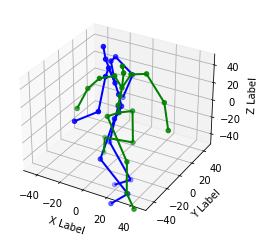

Epoch :  1
Batch : 0, Discriminator loss: 0.4714300036430359, Generator loss : 672.996440484271
Batch : 10, Discriminator loss: 0.454578697681427, Generator loss : 711.393650260806
Batch : 20, Discriminator loss: 0.5110157132148743, Generator loss : 516.7967583451796
Epoch 1 complete, Train cumulated Discriminator loss : 10.189030647277832, Train cumulated Generator loss : 13930.537998662578
Test Discriminator loss : 0.5059812664985657, Test Generator loss : 733.176201600545
29 0


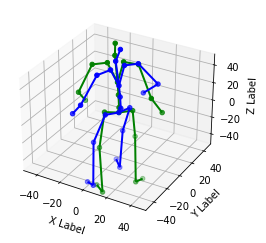

Epoch :  2
Batch : 0, Discriminator loss: 0.4731338620185852, Generator loss : 447.949259291077
Batch : 10, Discriminator loss: 0.3405224084854126, Generator loss : 630.5427231964162
Batch : 20, Discriminator loss: 0.3087312579154968, Generator loss : 542.4261091576709
Epoch 2 complete, Train cumulated Discriminator loss : 8.423755645751953, Train cumulated Generator loss : 12225.627897814788
Test Discriminator loss : 0.3501764237880707, Test Generator loss : 577.3334157678258
86 0


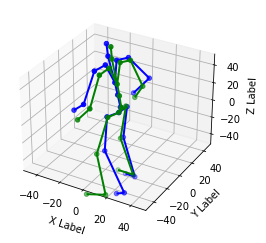

Epoch :  3
Batch : 0, Discriminator loss: 0.23440967500209808, Generator loss : 562.6524331899923
Batch : 10, Discriminator loss: 0.3949297070503235, Generator loss : 482.16689051416773
Batch : 20, Discriminator loss: 0.2656833827495575, Generator loss : 554.8973813791881
Epoch 3 complete, Train cumulated Discriminator loss : 7.424668788909912, Train cumulated Generator loss : 11787.864232624346
Test Discriminator loss : 0.29116594791412354, Test Generator loss : 622.6123341019961
60 5


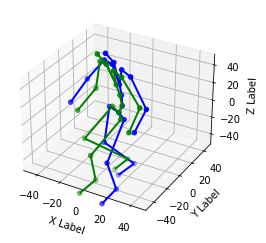

Epoch :  4
Batch : 0, Discriminator loss: 0.33736348152160645, Generator loss : 398.04149402329256
Batch : 10, Discriminator loss: 0.39082634449005127, Generator loss : 521.7045393537486
Batch : 20, Discriminator loss: 0.2271241545677185, Generator loss : 443.1506483632046
Epoch 4 complete, Train cumulated Discriminator loss : 7.102194309234619, Train cumulated Generator loss : 10656.91206891947
Test Discriminator loss : 0.3864075839519501, Test Generator loss : 495.65861000464025
12 2


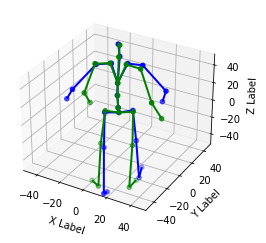

Epoch :  5
Batch : 0, Discriminator loss: 0.3812929093837738, Generator loss : 418.4032232457047
Batch : 10, Discriminator loss: 0.307062566280365, Generator loss : 530.7065568982101
Batch : 20, Discriminator loss: 0.29950258135795593, Generator loss : 450.61327026883475
Epoch 5 complete, Train cumulated Discriminator loss : 7.099876403808594, Train cumulated Generator loss : 9774.061794887268
Test Discriminator loss : 0.3329673409461975, Test Generator loss : 608.1676214566662
66 13


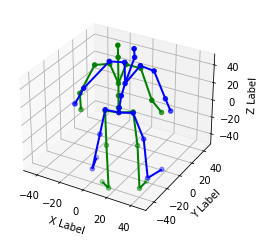

Epoch :  6
Batch : 0, Discriminator loss: 0.21011865139007568, Generator loss : 424.8311305373047
Batch : 10, Discriminator loss: 0.3801735043525696, Generator loss : 356.10807741742667
Batch : 20, Discriminator loss: 0.519584596157074, Generator loss : 347.70924951643997
Epoch 6 complete, Train cumulated Discriminator loss : 7.011624813079834, Train cumulated Generator loss : 9100.262393493724
Test Discriminator loss : 0.386709988117218, Test Generator loss : 760.0640761963416
75 5


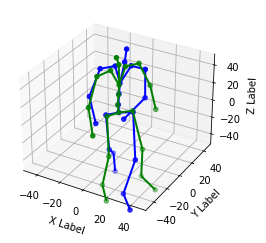

Epoch :  7
Batch : 0, Discriminator loss: 0.3821038007736206, Generator loss : 398.6454874268056
Batch : 10, Discriminator loss: 0.4076474606990814, Generator loss : 342.41295197834773
Batch : 20, Discriminator loss: 0.26629218459129333, Generator loss : 292.5819708570021
Epoch 7 complete, Train cumulated Discriminator loss : 7.341434478759766, Train cumulated Generator loss : 8598.253396215861
Test Discriminator loss : 0.3783037066459656, Test Generator loss : 507.0141061142199
34 4


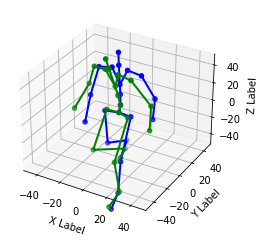

Epoch :  8
Batch : 0, Discriminator loss: 0.3277505338191986, Generator loss : 379.14354593520085
Batch : 10, Discriminator loss: 0.25849413871765137, Generator loss : 322.00672250006215
Batch : 20, Discriminator loss: 0.2284986674785614, Generator loss : 389.9612723760307
Epoch 8 complete, Train cumulated Discriminator loss : 6.187005043029785, Train cumulated Generator loss : 8119.588967236103
Test Discriminator loss : 0.2812827229499817, Test Generator loss : 752.3990912443544
68 13


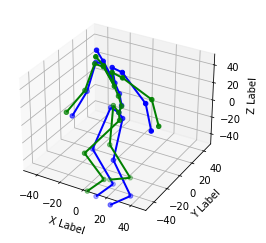

Epoch :  9
Batch : 0, Discriminator loss: 0.28156495094299316, Generator loss : 373.3916764731075
Batch : 10, Discriminator loss: 0.19700779020786285, Generator loss : 412.28466309756254
Batch : 20, Discriminator loss: 0.29207754135131836, Generator loss : 375.6135654282306
Epoch 9 complete, Train cumulated Discriminator loss : 6.16916036605835, Train cumulated Generator loss : 8088.658894861674
Test Discriminator loss : 0.24483484029769897, Test Generator loss : 857.1126938505855
48 12


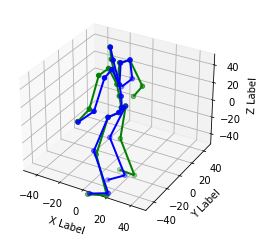

Epoch :  10
Batch : 0, Discriminator loss: 0.35323840379714966, Generator loss : 386.88643599821273
Batch : 10, Discriminator loss: 0.3421432375907898, Generator loss : 278.17991322910325
Batch : 20, Discriminator loss: 0.37904784083366394, Generator loss : 382.46356842098027
Epoch 10 complete, Train cumulated Discriminator loss : 6.739612102508545, Train cumulated Generator loss : 7627.42090510673
Test Discriminator loss : 0.22005346417427063, Test Generator loss : 1084.4611447167267
50 12


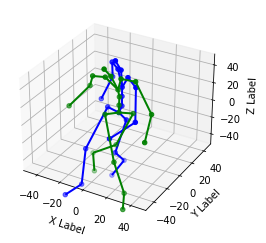

Epoch :  11
Batch : 0, Discriminator loss: 0.17829561233520508, Generator loss : 309.3950833014022
Batch : 10, Discriminator loss: 0.31635886430740356, Generator loss : 357.41072826708427
Batch : 20, Discriminator loss: 0.298379123210907, Generator loss : 237.8125376108783
Epoch 11 complete, Train cumulated Discriminator loss : 6.080127239227295, Train cumulated Generator loss : 7386.544076394994
Test Discriminator loss : 0.2672942280769348, Test Generator loss : 1145.6057401279984
7 14


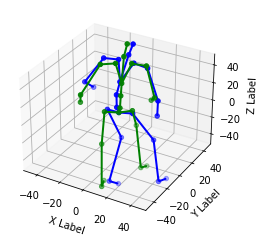

Epoch :  12
Batch : 0, Discriminator loss: 0.2752382755279541, Generator loss : 342.81829927274555
Batch : 10, Discriminator loss: 0.2649388313293457, Generator loss : 446.3391332436024
Batch : 20, Discriminator loss: 0.1779959499835968, Generator loss : 314.536088326746
Epoch 12 complete, Train cumulated Discriminator loss : 5.167887210845947, Train cumulated Generator loss : 7506.02484727
Test Discriminator loss : 0.265350878238678, Test Generator loss : 916.2138022468525
51 14


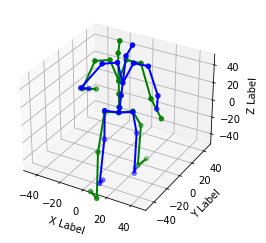

Epoch :  13
Batch : 0, Discriminator loss: 0.2824392318725586, Generator loss : 411.18767120352686
Batch : 10, Discriminator loss: 0.17150771617889404, Generator loss : 293.9013272183733
Batch : 20, Discriminator loss: 0.24003782868385315, Generator loss : 318.9025927423002
Epoch 13 complete, Train cumulated Discriminator loss : 5.631309986114502, Train cumulated Generator loss : 7526.869496912751
Test Discriminator loss : 0.18496191501617432, Test Generator loss : 607.3975627701637
57 15


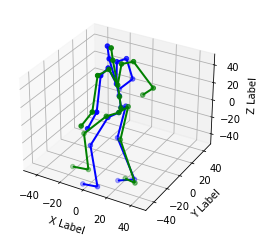

Epoch :  14
Batch : 0, Discriminator loss: 0.2589240074157715, Generator loss : 313.73197048843906
Batch : 10, Discriminator loss: 0.08862213045358658, Generator loss : 584.1038154335528
Batch : 20, Discriminator loss: 0.18151727318763733, Generator loss : 430.7154042567958
Epoch 14 complete, Train cumulated Discriminator loss : 4.440250873565674, Train cumulated Generator loss : 8392.931220695918
Test Discriminator loss : 0.19408851861953735, Test Generator loss : 626.2540762957974
35 1


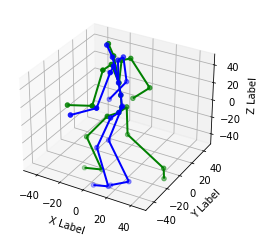

Epoch :  15
Batch : 0, Discriminator loss: 0.1407516896724701, Generator loss : 368.08335911885615
Batch : 10, Discriminator loss: 0.24616502225399017, Generator loss : 384.4185039494145
Batch : 20, Discriminator loss: 0.2945806384086609, Generator loss : 382.08499304670676
Epoch 15 complete, Train cumulated Discriminator loss : 4.914978504180908, Train cumulated Generator loss : 8067.1412393695
Test Discriminator loss : 0.1717594861984253, Test Generator loss : 559.2976916977786
56 11


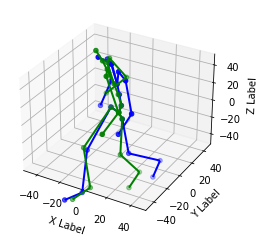

Epoch :  16
Batch : 0, Discriminator loss: 0.26390722393989563, Generator loss : 307.16351765620345
Batch : 10, Discriminator loss: 0.24049848318099976, Generator loss : 420.27517082774034
Batch : 20, Discriminator loss: 0.24339845776557922, Generator loss : 248.82367513305346
Epoch 16 complete, Train cumulated Discriminator loss : 3.92189884185791, Train cumulated Generator loss : 7563.70901411384
Test Discriminator loss : 0.22096538543701172, Test Generator loss : 465.83209580349256
68 11


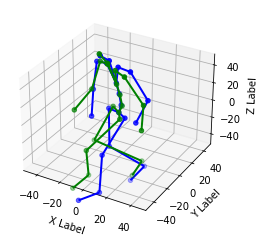

Epoch :  17
Batch : 0, Discriminator loss: 0.13500747084617615, Generator loss : 384.35439946128986
Batch : 10, Discriminator loss: 0.11894335597753525, Generator loss : 396.0499010877526
Batch : 20, Discriminator loss: 0.1480361670255661, Generator loss : 295.7611441578819
Epoch 17 complete, Train cumulated Discriminator loss : 3.2967917919158936, Train cumulated Generator loss : 7645.768697512298
Test Discriminator loss : 0.17156311869621277, Test Generator loss : 706.5439435743374
88 10


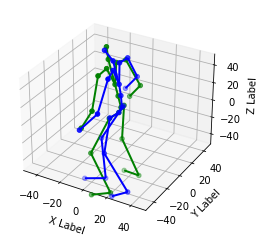

Epoch :  18
Batch : 0, Discriminator loss: 0.08189357817173004, Generator loss : 302.08608453242755
Batch : 10, Discriminator loss: 0.10058307647705078, Generator loss : 327.62933434941743
Batch : 20, Discriminator loss: 0.14632974565029144, Generator loss : 285.4704571129501
Epoch 18 complete, Train cumulated Discriminator loss : 2.497866153717041, Train cumulated Generator loss : 7511.936298021839
Test Discriminator loss : 0.10690493136644363, Test Generator loss : 707.3887539942482
50 4


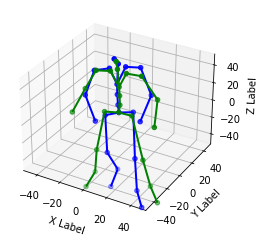

Epoch :  19
Batch : 0, Discriminator loss: 0.14761418104171753, Generator loss : 281.40069492468086
Batch : 10, Discriminator loss: 0.057677678763866425, Generator loss : 209.46320773626064
Batch : 20, Discriminator loss: 0.11234081536531448, Generator loss : 337.91110498334524
Epoch 19 complete, Train cumulated Discriminator loss : 3.155730724334717, Train cumulated Generator loss : 7522.812016353894
Test Discriminator loss : 0.14906364679336548, Test Generator loss : 475.1919968318494
90 9


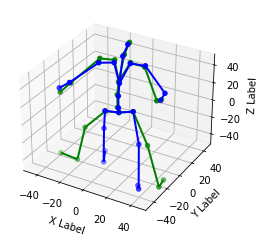

Epoch :  20
Batch : 0, Discriminator loss: 0.14986099302768707, Generator loss : 324.4274164057116
Batch : 10, Discriminator loss: 0.08172420412302017, Generator loss : 367.14923264151247
Batch : 20, Discriminator loss: 0.10179026424884796, Generator loss : 334.5521441776021
Epoch 20 complete, Train cumulated Discriminator loss : 2.7823081016540527, Train cumulated Generator loss : 7347.1096664826455
Test Discriminator loss : 0.17098650336265564, Test Generator loss : 731.8499827278434
23 9


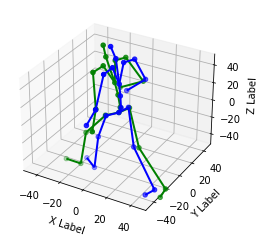

Epoch :  21
Batch : 0, Discriminator loss: 0.05661735683679581, Generator loss : 346.1255187517419
Batch : 10, Discriminator loss: 0.14009793102741241, Generator loss : 262.4216596534347
Batch : 20, Discriminator loss: 0.14846616983413696, Generator loss : 398.04267108950546
Epoch 21 complete, Train cumulated Discriminator loss : 2.1218442916870117, Train cumulated Generator loss : 7336.427302158686
Test Discriminator loss : 0.0892568975687027, Test Generator loss : 956.3763095283293
72 10


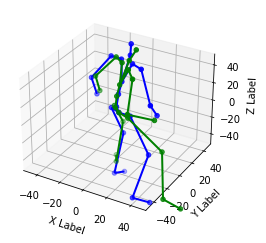

Epoch :  22
Batch : 0, Discriminator loss: 0.05844969302415848, Generator loss : 342.7450115966163
Batch : 10, Discriminator loss: 0.15840688347816467, Generator loss : 411.5742413389581
Batch : 20, Discriminator loss: 0.0845455676317215, Generator loss : 285.7589419840256
Epoch 22 complete, Train cumulated Discriminator loss : 2.3754079341888428, Train cumulated Generator loss : 7471.087950764127
Test Discriminator loss : 0.1563405841588974, Test Generator loss : 589.0596957876304
40 3


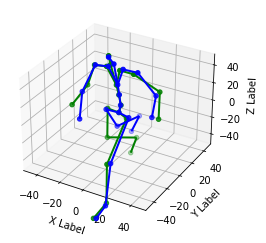

Epoch :  23
Batch : 0, Discriminator loss: 0.13963259756565094, Generator loss : 294.3847951199875
Batch : 10, Discriminator loss: 0.05915488675236702, Generator loss : 298.258674299696
Batch : 20, Discriminator loss: 0.04670494794845581, Generator loss : 291.9464136698156
Epoch 23 complete, Train cumulated Discriminator loss : 2.4454610347747803, Train cumulated Generator loss : 7413.89617437128
Test Discriminator loss : 0.08776772022247314, Test Generator loss : 548.8375451754039
83 8


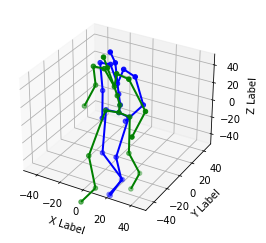

Epoch :  24
Batch : 0, Discriminator loss: 0.15286409854888916, Generator loss : 314.380634151363
Batch : 10, Discriminator loss: 0.06380793452262878, Generator loss : 355.4104289543042
Batch : 20, Discriminator loss: 0.03636495769023895, Generator loss : 336.51253187134125
Epoch 24 complete, Train cumulated Discriminator loss : 2.119192123413086, Train cumulated Generator loss : 7352.4729342974315
Test Discriminator loss : 0.07916063070297241, Test Generator loss : 558.5587340526548
18 0


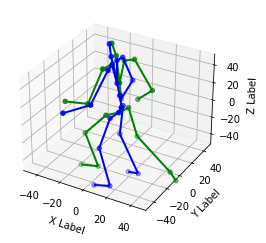

Epoch :  25
Batch : 0, Discriminator loss: 0.07437029480934143, Generator loss : 391.4156239144586
Batch : 10, Discriminator loss: 0.04565363749861717, Generator loss : 307.61266548386914
Batch : 20, Discriminator loss: 0.04070064425468445, Generator loss : 242.07868711764226
Epoch 25 complete, Train cumulated Discriminator loss : 1.6360290050506592, Train cumulated Generator loss : 7252.501516596255
Test Discriminator loss : 0.07474745810031891, Test Generator loss : 702.6839563068564
22 11


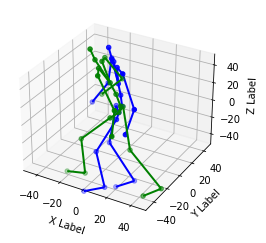

Epoch :  26
Batch : 0, Discriminator loss: 0.15615813434123993, Generator loss : 253.04307761318606
Batch : 10, Discriminator loss: 0.16376253962516785, Generator loss : 341.26459065327776
Batch : 20, Discriminator loss: 0.055245742201805115, Generator loss : 384.04856670477665
Epoch 26 complete, Train cumulated Discriminator loss : 2.106532096862793, Train cumulated Generator loss : 7323.460873699446
Test Discriminator loss : 0.1253351867198944, Test Generator loss : 613.7520283353015
83 0


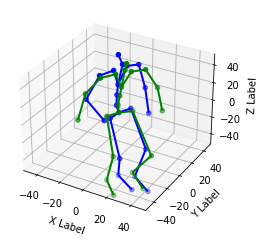

Epoch :  27
Batch : 0, Discriminator loss: 0.13422563672065735, Generator loss : 371.3326840242969
Batch : 10, Discriminator loss: 0.0957409143447876, Generator loss : 294.52655717642426
Batch : 20, Discriminator loss: 0.16258753836154938, Generator loss : 309.58538653448244
Epoch 27 complete, Train cumulated Discriminator loss : 3.1780543327331543, Train cumulated Generator loss : 7329.253058881347
Test Discriminator loss : 0.18637613952159882, Test Generator loss : 673.855971279102
10 13


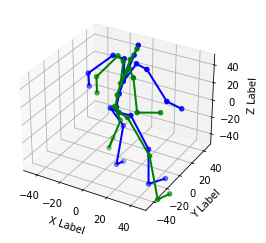

Epoch :  28
Batch : 0, Discriminator loss: 0.2038939744234085, Generator loss : 227.30506746834843
Batch : 10, Discriminator loss: 0.2538365423679352, Generator loss : 360.0782197950183
Batch : 20, Discriminator loss: 0.25988489389419556, Generator loss : 453.94375309608847
Epoch 28 complete, Train cumulated Discriminator loss : 4.204776763916016, Train cumulated Generator loss : 7319.80177151809
Test Discriminator loss : 0.10827812552452087, Test Generator loss : 1005.8113919980219
50 0


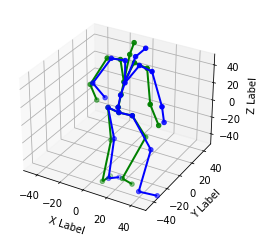

Epoch :  29
Batch : 0, Discriminator loss: 0.1444340944290161, Generator loss : 271.35728442915786
Batch : 10, Discriminator loss: 0.10987158119678497, Generator loss : 299.3562374392491
Batch : 20, Discriminator loss: 0.03813346475362778, Generator loss : 359.96279378406075
Epoch 29 complete, Train cumulated Discriminator loss : 2.253084182739258, Train cumulated Generator loss : 7937.15227261675
Test Discriminator loss : 0.20286308228969574, Test Generator loss : 626.1696062277002
26 6


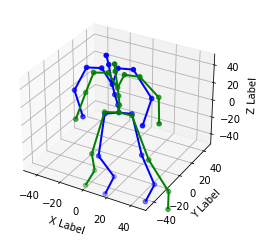

Epoch :  30
Batch : 0, Discriminator loss: 0.16663594543933868, Generator loss : 250.86042718532403
Batch : 10, Discriminator loss: 0.08774345368146896, Generator loss : 374.85948466477083
Batch : 20, Discriminator loss: 0.03419565036892891, Generator loss : 500.06667105897526
Epoch 30 complete, Train cumulated Discriminator loss : 2.623624801635742, Train cumulated Generator loss : 9547.233450560134
Test Discriminator loss : 0.0754154622554779, Test Generator loss : 565.547036615628
30 9


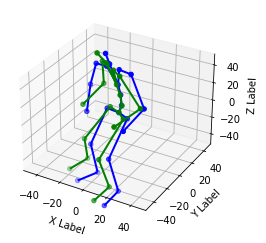

Epoch :  31
Batch : 0, Discriminator loss: 0.06318502128124237, Generator loss : 500.6785037689017
Batch : 10, Discriminator loss: 0.07582324743270874, Generator loss : 411.55166488304883
Batch : 20, Discriminator loss: 0.13552230596542358, Generator loss : 460.0245334295052
Epoch 31 complete, Train cumulated Discriminator loss : 1.4343785047531128, Train cumulated Generator loss : 9282.789733541811
Test Discriminator loss : 0.13709452748298645, Test Generator loss : 717.5383488921213
72 12


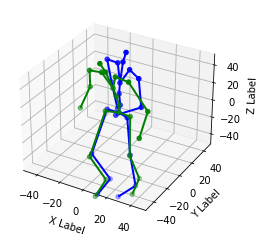

Epoch :  32
Batch : 0, Discriminator loss: 0.10333138704299927, Generator loss : 308.24386771902584
Batch : 10, Discriminator loss: 0.14758458733558655, Generator loss : 396.7624566188992
Batch : 20, Discriminator loss: 0.23805952072143555, Generator loss : 368.5622883830458
Epoch 32 complete, Train cumulated Discriminator loss : 2.442861795425415, Train cumulated Generator loss : 8316.749850764974
Test Discriminator loss : 0.11176986992359161, Test Generator loss : 559.6422513806456
70 12


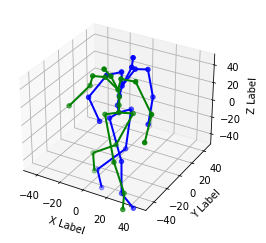

Epoch :  33
Batch : 0, Discriminator loss: 0.09190461784601212, Generator loss : 421.7177210806979
Batch : 10, Discriminator loss: 0.10506167262792587, Generator loss : 356.5448166221467
Batch : 20, Discriminator loss: 0.16569548845291138, Generator loss : 411.96346642086866
Epoch 33 complete, Train cumulated Discriminator loss : 2.525663137435913, Train cumulated Generator loss : 8077.061231198355
Test Discriminator loss : 0.16948285698890686, Test Generator loss : 425.81568860759245
65 4


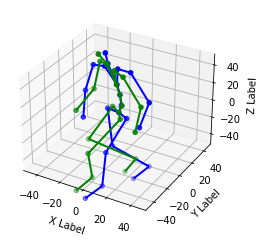

Epoch :  34
Batch : 0, Discriminator loss: 0.02179805189371109, Generator loss : 336.80707758520185
Batch : 10, Discriminator loss: 0.08185365796089172, Generator loss : 368.8813530437539
Batch : 20, Discriminator loss: 0.19657370448112488, Generator loss : 380.54585268820745
Epoch 34 complete, Train cumulated Discriminator loss : 3.440812110900879, Train cumulated Generator loss : 7637.5445679401555
Test Discriminator loss : 0.13764706254005432, Test Generator loss : 531.7621658345706
37 1


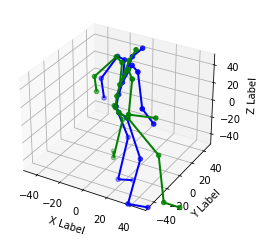

Epoch :  35
Batch : 0, Discriminator loss: 0.0836598128080368, Generator loss : 334.2281660951748
Batch : 10, Discriminator loss: 0.19703222811222076, Generator loss : 330.5616546411021
Batch : 20, Discriminator loss: 0.1347302496433258, Generator loss : 356.74565876980563
Epoch 35 complete, Train cumulated Discriminator loss : 3.2417891025543213, Train cumulated Generator loss : 7480.289232129386
Test Discriminator loss : 0.16184376180171967, Test Generator loss : 722.5761732399044
71 11


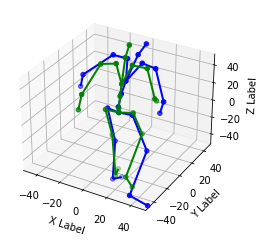

Epoch :  36
Batch : 0, Discriminator loss: 0.2959870398044586, Generator loss : 277.9953885187175
Batch : 10, Discriminator loss: 0.14456549286842346, Generator loss : 373.7549299809209
Batch : 20, Discriminator loss: 0.17167609930038452, Generator loss : 389.728733033487
Epoch 36 complete, Train cumulated Discriminator loss : 3.6592607498168945, Train cumulated Generator loss : 7480.679600139776
Test Discriminator loss : 0.30095285177230835, Test Generator loss : 842.4615252062492
47 5


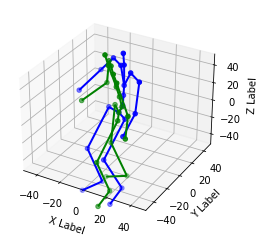

Epoch :  37
Batch : 0, Discriminator loss: 0.21522392332553864, Generator loss : 317.2988873551463
Batch : 10, Discriminator loss: 0.11700171232223511, Generator loss : 303.9265659160977
Batch : 20, Discriminator loss: 0.18885813653469086, Generator loss : 286.68941999235494
Epoch 37 complete, Train cumulated Discriminator loss : 4.244846820831299, Train cumulated Generator loss : 7332.083473618261
Test Discriminator loss : 0.09799449145793915, Test Generator loss : 546.7844597431443
64 12


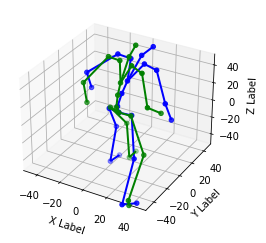

Epoch :  38
Batch : 0, Discriminator loss: 0.21477010846138, Generator loss : 370.5972842476032
Batch : 10, Discriminator loss: 0.15433849394321442, Generator loss : 275.8084028523137
Batch : 20, Discriminator loss: 0.17779788374900818, Generator loss : 302.3913045103048
Epoch 38 complete, Train cumulated Discriminator loss : 2.987300157546997, Train cumulated Generator loss : 7379.14859035665
Test Discriminator loss : 0.1830493062734604, Test Generator loss : 618.758881700507
13 6


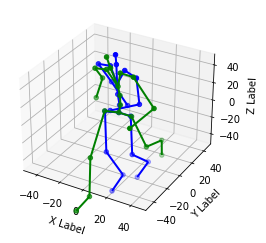

Epoch :  39
Batch : 0, Discriminator loss: 0.21599361300468445, Generator loss : 307.28909466797086
Batch : 10, Discriminator loss: 0.2127244621515274, Generator loss : 301.1317758191748
Batch : 20, Discriminator loss: 0.21930061280727386, Generator loss : 288.5493371126595
Epoch 39 complete, Train cumulated Discriminator loss : 3.7422006130218506, Train cumulated Generator loss : 7049.947882538462
Test Discriminator loss : 0.22535941004753113, Test Generator loss : 617.0028118931075
4 1


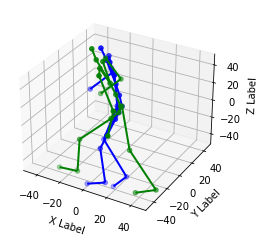

Epoch :  40
Batch : 0, Discriminator loss: 0.13813143968582153, Generator loss : 294.5113639966619
Batch : 10, Discriminator loss: 0.11175792664289474, Generator loss : 457.1282164845288
Batch : 20, Discriminator loss: 0.15944799780845642, Generator loss : 323.7101335351503
Epoch 40 complete, Train cumulated Discriminator loss : 3.929913282394409, Train cumulated Generator loss : 7175.2990129887185
Test Discriminator loss : 0.1605684906244278, Test Generator loss : 741.4103266444309
8 5


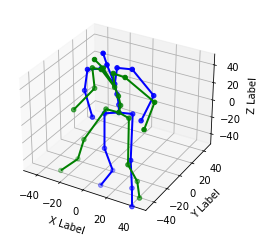

Epoch :  41
Batch : 0, Discriminator loss: 0.15001831948757172, Generator loss : 368.3967073472982
Batch : 10, Discriminator loss: 0.1526513248682022, Generator loss : 363.14617105611495
Batch : 20, Discriminator loss: 0.10592998564243317, Generator loss : 266.67002218410727
Epoch 41 complete, Train cumulated Discriminator loss : 4.484808921813965, Train cumulated Generator loss : 7094.386412738646
Test Discriminator loss : 0.3037109375, Test Generator loss : 472.6619884772046
92 15


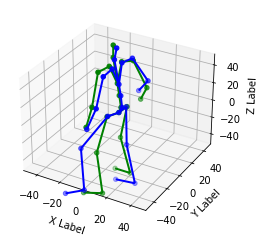

Epoch :  42
Batch : 0, Discriminator loss: 0.2606586515903473, Generator loss : 293.5362381114755
Batch : 10, Discriminator loss: 0.3068866729736328, Generator loss : 374.95497413405957
Batch : 20, Discriminator loss: 0.11573997139930725, Generator loss : 318.3985612150205
Epoch 42 complete, Train cumulated Discriminator loss : 4.6424641609191895, Train cumulated Generator loss : 7101.210668360002
Test Discriminator loss : 0.16473904252052307, Test Generator loss : 518.856378021847
87 1


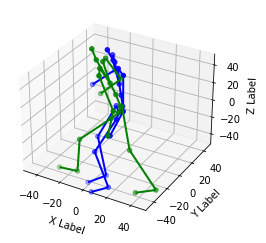

Epoch :  43
Batch : 0, Discriminator loss: 0.1345246136188507, Generator loss : 388.23590701812515
Batch : 10, Discriminator loss: 0.19951823353767395, Generator loss : 335.4283541641725
Batch : 20, Discriminator loss: 0.25362545251846313, Generator loss : 340.60236943997114
Epoch 43 complete, Train cumulated Discriminator loss : 5.284844398498535, Train cumulated Generator loss : 6897.71591446612
Test Discriminator loss : 0.24483686685562134, Test Generator loss : 616.6351883080489
46 14


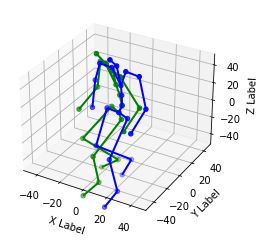

Epoch :  44
Batch : 0, Discriminator loss: 0.2588723301887512, Generator loss : 312.3312673754468
Batch : 10, Discriminator loss: 0.23809239268302917, Generator loss : 391.16232942274155
Batch : 20, Discriminator loss: 0.06673327088356018, Generator loss : 292.3056606446173
Epoch 44 complete, Train cumulated Discriminator loss : 5.213040351867676, Train cumulated Generator loss : 6879.300921963083
Test Discriminator loss : 0.20079872012138367, Test Generator loss : 619.9799342656128
80 6


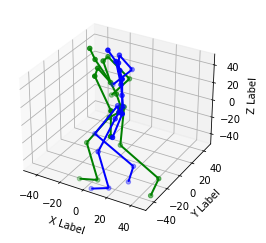

Epoch :  45
Batch : 0, Discriminator loss: 0.1678144335746765, Generator loss : 286.2557975734756
Batch : 10, Discriminator loss: 0.08783576637506485, Generator loss : 304.92895646351553
Batch : 20, Discriminator loss: 0.1456289142370224, Generator loss : 329.2438512773031
Epoch 45 complete, Train cumulated Discriminator loss : 4.429841041564941, Train cumulated Generator loss : 6921.794109537677
Test Discriminator loss : 0.21643999218940735, Test Generator loss : 777.2406796090935
0 13


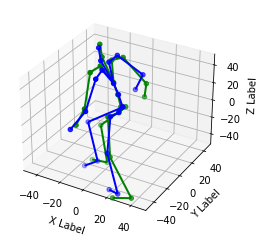

Epoch :  46
Batch : 0, Discriminator loss: 0.27131223678588867, Generator loss : 362.58042505558245
Batch : 10, Discriminator loss: 0.21127662062644958, Generator loss : 393.39588248902083
Batch : 20, Discriminator loss: 0.4027201533317566, Generator loss : 329.25555157860407
Epoch 46 complete, Train cumulated Discriminator loss : 4.744013786315918, Train cumulated Generator loss : 6720.417107533806
Test Discriminator loss : 0.2412235140800476, Test Generator loss : 540.4543730630826
52 12


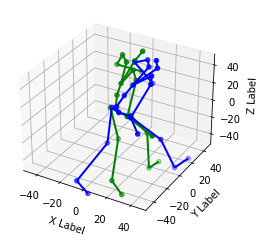

Epoch :  47
Batch : 0, Discriminator loss: 0.18005308508872986, Generator loss : 300.3452403092952
Batch : 10, Discriminator loss: 0.1334255039691925, Generator loss : 308.38579549120595
Batch : 20, Discriminator loss: 0.12705150246620178, Generator loss : 295.5691198152421
Epoch 47 complete, Train cumulated Discriminator loss : 4.074844837188721, Train cumulated Generator loss : 6728.085442996401
Test Discriminator loss : 0.21735265851020813, Test Generator loss : 549.0881202502536
70 4


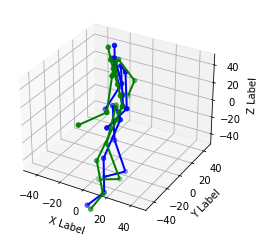

Epoch :  48
Batch : 0, Discriminator loss: 0.20228727161884308, Generator loss : 308.5243933409537
Batch : 10, Discriminator loss: 0.07876789569854736, Generator loss : 304.92464388790796
Batch : 20, Discriminator loss: 0.050496991723775864, Generator loss : 358.33490155087077
Epoch 48 complete, Train cumulated Discriminator loss : 4.2776618003845215, Train cumulated Generator loss : 6741.946803702682
Test Discriminator loss : 0.11826545000076294, Test Generator loss : 712.9992083228155
57 13


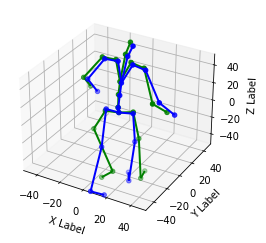

Epoch :  49
Batch : 0, Discriminator loss: 0.18163129687309265, Generator loss : 328.71076638583156
Batch : 10, Discriminator loss: 0.20034176111221313, Generator loss : 287.61480946310456
Batch : 20, Discriminator loss: 0.1970769464969635, Generator loss : 297.9611818839492
Epoch 49 complete, Train cumulated Discriminator loss : 3.989116668701172, Train cumulated Generator loss : 6721.483942565805
Test Discriminator loss : 0.12033891677856445, Test Generator loss : 716.8813673728637
82 14


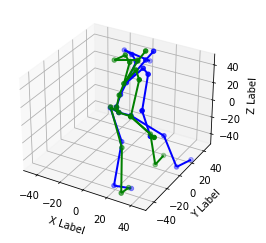

Epoch :  50
Batch : 0, Discriminator loss: 0.18523922562599182, Generator loss : 374.50995263524
Batch : 10, Discriminator loss: 0.12949401140213013, Generator loss : 278.321007024128
Batch : 20, Discriminator loss: 0.0893496721982956, Generator loss : 371.0842810218125
Epoch 50 complete, Train cumulated Discriminator loss : 3.2284867763519287, Train cumulated Generator loss : 6891.612595285526
Test Discriminator loss : 0.24944135546684265, Test Generator loss : 758.6303656585226
75 0


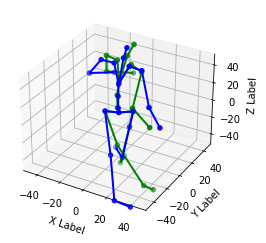

Epoch :  51
Batch : 0, Discriminator loss: 0.1743154227733612, Generator loss : 268.9700638843911
Batch : 10, Discriminator loss: 0.02011597342789173, Generator loss : 258.29977949173593
Batch : 20, Discriminator loss: 0.1311468482017517, Generator loss : 295.84952069193554
Epoch 51 complete, Train cumulated Discriminator loss : 3.5387630462646484, Train cumulated Generator loss : 6607.597401064741
Test Discriminator loss : 0.14110983908176422, Test Generator loss : 783.173810686108
43 12


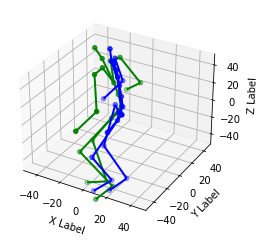

Epoch :  52
Batch : 0, Discriminator loss: 0.2469913363456726, Generator loss : 314.251984916439
Batch : 10, Discriminator loss: 0.11809835582971573, Generator loss : 305.06421902891105
Batch : 20, Discriminator loss: 0.06329385191202164, Generator loss : 295.96731351960216
Epoch 52 complete, Train cumulated Discriminator loss : 2.981691837310791, Train cumulated Generator loss : 6715.917905190312
Test Discriminator loss : 0.2181270271539688, Test Generator loss : 539.583336878653
40 15


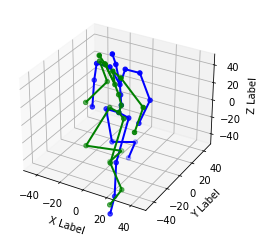

Epoch :  53
Batch : 0, Discriminator loss: 0.2955946624279022, Generator loss : 253.60913066447335
Batch : 10, Discriminator loss: 0.24366000294685364, Generator loss : 238.33760043546116
Batch : 20, Discriminator loss: 0.18268226087093353, Generator loss : 269.0844973879058
Epoch 53 complete, Train cumulated Discriminator loss : 3.6262874603271484, Train cumulated Generator loss : 6595.680861882156
Test Discriminator loss : 0.22920085489749908, Test Generator loss : 705.0579600725729
96 7


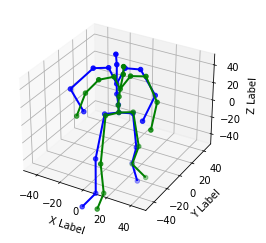

Epoch :  54
Batch : 0, Discriminator loss: 0.15922009944915771, Generator loss : 315.2153999300976
Batch : 10, Discriminator loss: 0.07185418903827667, Generator loss : 391.8759958309657
Batch : 20, Discriminator loss: 0.312854528427124, Generator loss : 299.69147230028244
Epoch 54 complete, Train cumulated Discriminator loss : 2.9365906715393066, Train cumulated Generator loss : 6736.916886057245
Test Discriminator loss : 0.1815519481897354, Test Generator loss : 755.0863478213777
13 5


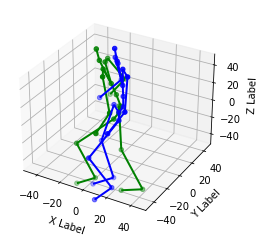

Epoch :  55
Batch : 0, Discriminator loss: 0.1919563263654709, Generator loss : 275.56980252092734
Batch : 10, Discriminator loss: 0.26578521728515625, Generator loss : 260.84548263626664
Batch : 20, Discriminator loss: 0.0969226062297821, Generator loss : 310.24723823990894
Epoch 55 complete, Train cumulated Discriminator loss : 3.170722007751465, Train cumulated Generator loss : 6713.013065953421
Test Discriminator loss : 0.18345290422439575, Test Generator loss : 779.0451831247298
57 5


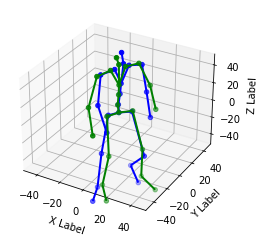

Epoch :  56
Batch : 0, Discriminator loss: 0.23080523312091827, Generator loss : 264.17242261389396
Batch : 10, Discriminator loss: 0.13646739721298218, Generator loss : 267.4898359797257
Batch : 20, Discriminator loss: 0.12691941857337952, Generator loss : 391.4712152837274
Epoch 56 complete, Train cumulated Discriminator loss : 3.40733003616333, Train cumulated Generator loss : 6484.5270801567685
Test Discriminator loss : 0.1025070995092392, Test Generator loss : 812.8086127019088
93 3


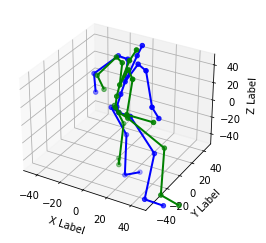

Epoch :  57
Batch : 0, Discriminator loss: 0.2525753676891327, Generator loss : 310.79360128747345
Batch : 10, Discriminator loss: 0.2822266221046448, Generator loss : 313.8042495590444
Batch : 20, Discriminator loss: 0.14376841485500336, Generator loss : 285.1456118655497
Epoch 57 complete, Train cumulated Discriminator loss : 3.7405550479888916, Train cumulated Generator loss : 6531.47845165756
Test Discriminator loss : 0.1700972020626068, Test Generator loss : 868.6952883256155
96 12


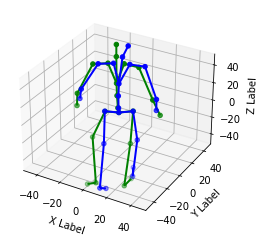

Epoch :  58
Batch : 0, Discriminator loss: 0.08623941242694855, Generator loss : 413.09092044011544
Batch : 10, Discriminator loss: 0.272126704454422, Generator loss : 184.93265900228522
Batch : 20, Discriminator loss: 0.09887054562568665, Generator loss : 276.79386461183424
Epoch 58 complete, Train cumulated Discriminator loss : 2.8738367557525635, Train cumulated Generator loss : 6462.694409448996
Test Discriminator loss : 0.10108968615531921, Test Generator loss : 765.2414809396769
55 4


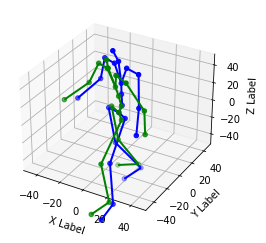

Epoch :  59
Batch : 0, Discriminator loss: 0.11082464456558228, Generator loss : 231.6607117506696
Batch : 10, Discriminator loss: 0.15402862429618835, Generator loss : 321.4862398017937
Batch : 20, Discriminator loss: 0.19734163582324982, Generator loss : 309.42243918662456
Epoch 59 complete, Train cumulated Discriminator loss : 2.6399357318878174, Train cumulated Generator loss : 6499.095532176362
Test Discriminator loss : 0.056585893034935, Test Generator loss : 946.1699196832151
41 15


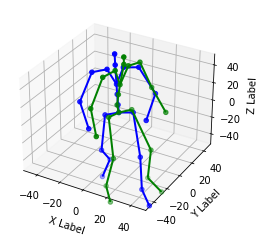

Epoch :  60
Batch : 0, Discriminator loss: 0.044827599078416824, Generator loss : 296.0993890041574
Batch : 10, Discriminator loss: 0.14912794530391693, Generator loss : 201.78470903335392
Batch : 20, Discriminator loss: 0.18796339631080627, Generator loss : 308.78410969038
Epoch 60 complete, Train cumulated Discriminator loss : 2.1192169189453125, Train cumulated Generator loss : 6750.261983091351
Test Discriminator loss : 0.09166978299617767, Test Generator loss : 729.8420669320351
31 11


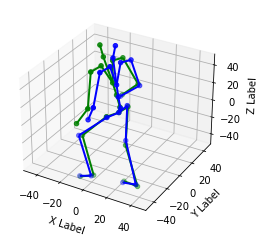

Epoch :  61
Batch : 0, Discriminator loss: 0.4062669575214386, Generator loss : 268.78862799568344
Batch : 10, Discriminator loss: 0.13397525250911713, Generator loss : 372.24147122156285
Batch : 20, Discriminator loss: 0.09048771858215332, Generator loss : 255.32531462551222
Epoch 61 complete, Train cumulated Discriminator loss : 2.614973306655884, Train cumulated Generator loss : 6648.445746135258
Test Discriminator loss : 0.15958590805530548, Test Generator loss : 636.9687105741934
14 2


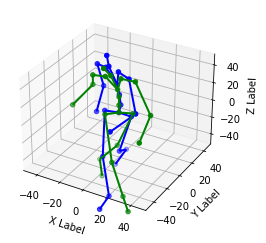

Epoch :  62
Batch : 0, Discriminator loss: 0.087155781686306, Generator loss : 210.69084252643353
Batch : 10, Discriminator loss: 0.07502903044223785, Generator loss : 297.24424312912015
Batch : 20, Discriminator loss: 0.14017945528030396, Generator loss : 349.72961276373206
Epoch 62 complete, Train cumulated Discriminator loss : 1.6486936807632446, Train cumulated Generator loss : 6662.04380025433
Test Discriminator loss : 0.08815927803516388, Test Generator loss : 675.6653159829485
28 3


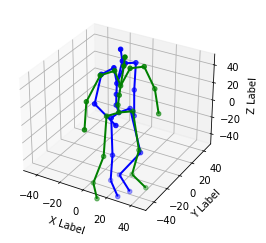

Epoch :  63
Batch : 0, Discriminator loss: 0.13875190913677216, Generator loss : 319.74022508601337
Batch : 10, Discriminator loss: 0.0074812863022089005, Generator loss : 294.0168710909997
Batch : 20, Discriminator loss: 0.04548889398574829, Generator loss : 273.1488814533235
Epoch 63 complete, Train cumulated Discriminator loss : 2.043114185333252, Train cumulated Generator loss : 6584.065097978224
Test Discriminator loss : 0.17677122354507446, Test Generator loss : 664.4954235179798
11 4


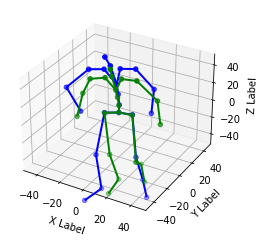

Epoch :  64
Batch : 0, Discriminator loss: 0.05464102327823639, Generator loss : 203.56451586605155
Batch : 10, Discriminator loss: 0.24020566046237946, Generator loss : 359.2509387511333
Batch : 20, Discriminator loss: 0.08996682614088058, Generator loss : 294.76668983511365
Epoch 64 complete, Train cumulated Discriminator loss : 2.5687057971954346, Train cumulated Generator loss : 6508.9125160336625
Test Discriminator loss : 0.12083914875984192, Test Generator loss : 577.7386615858363
33 6


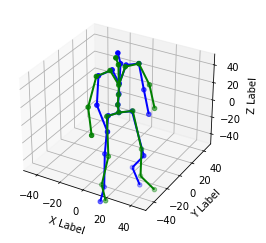

Epoch :  65
Batch : 0, Discriminator loss: 0.09265715628862381, Generator loss : 301.3151955491894
Batch : 10, Discriminator loss: 0.0776812806725502, Generator loss : 290.43887617081185
Batch : 20, Discriminator loss: 0.010959157720208168, Generator loss : 361.4416569357516
Epoch 65 complete, Train cumulated Discriminator loss : 1.8691248893737793, Train cumulated Generator loss : 6669.598197269023
Test Discriminator loss : 0.08537988364696503, Test Generator loss : 865.401425493492
27 7


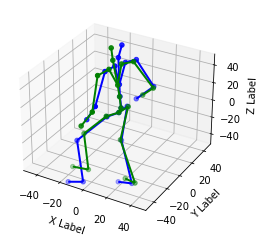

Epoch :  66
Batch : 0, Discriminator loss: 0.055877480655908585, Generator loss : 289.01691878440363
Batch : 10, Discriminator loss: 0.15728718042373657, Generator loss : 313.02983655734164
Batch : 20, Discriminator loss: 0.10744521766901016, Generator loss : 312.7180777330623
Epoch 66 complete, Train cumulated Discriminator loss : 1.9758155345916748, Train cumulated Generator loss : 6660.301265181998
Test Discriminator loss : 0.07234422862529755, Test Generator loss : 509.2585891980042
23 5


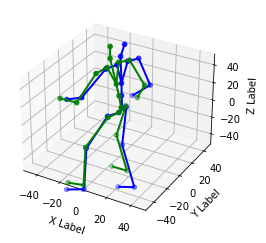

Epoch :  67
Batch : 0, Discriminator loss: 0.12134267389774323, Generator loss : 314.05107349382985
Batch : 10, Discriminator loss: 0.038378797471523285, Generator loss : 359.0317324014575
Batch : 20, Discriminator loss: 0.015944011509418488, Generator loss : 304.1444959675826
Epoch 67 complete, Train cumulated Discriminator loss : 1.5085508823394775, Train cumulated Generator loss : 6707.188917026937
Test Discriminator loss : 0.07529293745756149, Test Generator loss : 542.6511273443566
56 11


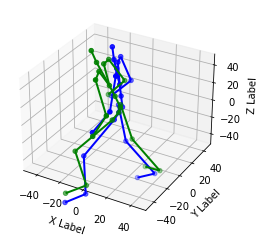

Epoch :  68
Batch : 0, Discriminator loss: 0.0781790092587471, Generator loss : 276.78201577548833
Batch : 10, Discriminator loss: 0.037629012018442154, Generator loss : 313.0694076046516
Batch : 20, Discriminator loss: 0.07111895829439163, Generator loss : 293.3377378249149
Epoch 68 complete, Train cumulated Discriminator loss : 1.9014253616333008, Train cumulated Generator loss : 6624.573782562792
Test Discriminator loss : 0.07797626405954361, Test Generator loss : 736.7074188607097
12 4


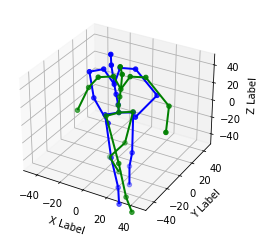

Epoch :  69
Batch : 0, Discriminator loss: 0.07719697803258896, Generator loss : 220.2405607139726
Batch : 10, Discriminator loss: 0.051501814275979996, Generator loss : 299.05009860693843
Batch : 20, Discriminator loss: 0.05219808220863342, Generator loss : 295.7663836040225
Epoch 69 complete, Train cumulated Discriminator loss : 1.565193772315979, Train cumulated Generator loss : 6659.0529320652795
Test Discriminator loss : 0.07311542332172394, Test Generator loss : 648.577038961674
9 0


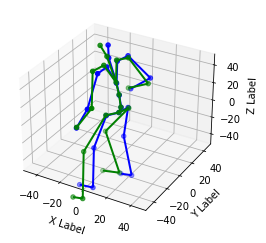

Epoch :  70
Batch : 0, Discriminator loss: 0.04493065923452377, Generator loss : 320.89819706173097
Batch : 10, Discriminator loss: 0.04988861829042435, Generator loss : 247.25817199625612
Batch : 20, Discriminator loss: 0.09110329300165176, Generator loss : 266.82251631612496
Epoch 70 complete, Train cumulated Discriminator loss : 1.587510585784912, Train cumulated Generator loss : 6738.616410646522
Test Discriminator loss : 0.05734606832265854, Test Generator loss : 1113.8729113418096
12 3


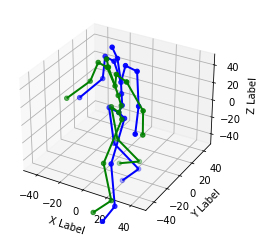

Epoch :  71
Batch : 0, Discriminator loss: 0.015526723116636276, Generator loss : 300.7642600940927
Batch : 10, Discriminator loss: 0.01626419834792614, Generator loss : 256.9536882992595
Batch : 20, Discriminator loss: 0.12149196118116379, Generator loss : 267.2970339162788
Epoch 71 complete, Train cumulated Discriminator loss : 1.432971477508545, Train cumulated Generator loss : 6757.454250501461
Test Discriminator loss : 0.08738704770803452, Test Generator loss : 552.1251172499741
67 13


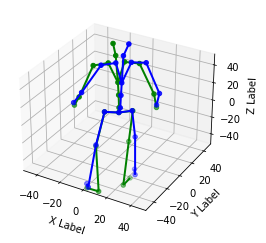

Epoch :  72
Batch : 0, Discriminator loss: 0.01357245072722435, Generator loss : 404.80515332662554
Batch : 10, Discriminator loss: 0.0975019782781601, Generator loss : 359.51130829439194
Batch : 20, Discriminator loss: 0.08042771369218826, Generator loss : 269.89726987729716
Epoch 72 complete, Train cumulated Discriminator loss : 1.3377399444580078, Train cumulated Generator loss : 6608.567010765666
Test Discriminator loss : 0.07670566439628601, Test Generator loss : 685.3554804830417
82 2


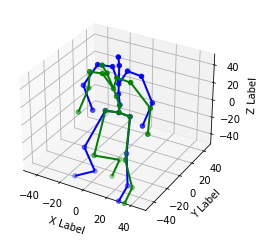

Epoch :  73
Batch : 0, Discriminator loss: 0.061527326703071594, Generator loss : 326.6899124486707
Batch : 10, Discriminator loss: 0.0659610852599144, Generator loss : 227.17893903499223
Batch : 20, Discriminator loss: 0.06678955256938934, Generator loss : 317.64506645952224
Epoch 73 complete, Train cumulated Discriminator loss : 2.4339122772216797, Train cumulated Generator loss : 6673.725208130292
Test Discriminator loss : 0.1282968372106552, Test Generator loss : 944.405763931863
27 9


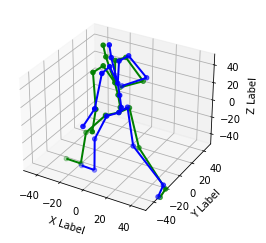

Epoch :  74
Batch : 0, Discriminator loss: 0.11585657298564911, Generator loss : 181.37595986130162
Batch : 10, Discriminator loss: 0.11933624744415283, Generator loss : 309.86201303060074
Batch : 20, Discriminator loss: 0.015262946486473083, Generator loss : 366.32978983742976
Epoch 74 complete, Train cumulated Discriminator loss : 2.1604409217834473, Train cumulated Generator loss : 6706.765894392583
Test Discriminator loss : 0.1369883269071579, Test Generator loss : 1202.600023052981
82 4


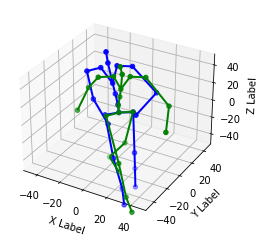

Epoch :  75
Batch : 0, Discriminator loss: 0.03264988958835602, Generator loss : 272.63297554344416
Batch : 10, Discriminator loss: 0.03715527057647705, Generator loss : 262.97025732634523
Batch : 20, Discriminator loss: 0.020760614424943924, Generator loss : 337.8057395475764
Epoch 75 complete, Train cumulated Discriminator loss : 1.5448018312454224, Train cumulated Generator loss : 6738.572571543111
Test Discriminator loss : 0.0922243744134903, Test Generator loss : 926.695971975779
1 12


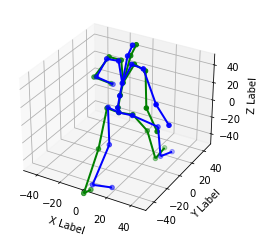

Epoch :  76
Batch : 0, Discriminator loss: 0.08645421266555786, Generator loss : 298.08645153649724
Batch : 10, Discriminator loss: 0.02580246701836586, Generator loss : 218.14448215796733
Batch : 20, Discriminator loss: 0.2662862539291382, Generator loss : 257.32066758705116
Epoch 76 complete, Train cumulated Discriminator loss : 2.1954104900360107, Train cumulated Generator loss : 6686.820167551081
Test Discriminator loss : 0.15191850066184998, Test Generator loss : 845.1576771543632
68 15


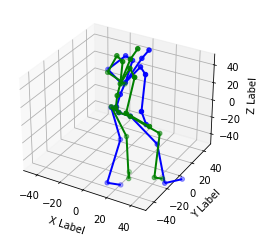

Epoch :  77
Batch : 0, Discriminator loss: 0.03582960367202759, Generator loss : 256.64298702703616
Batch : 10, Discriminator loss: 0.06801068782806396, Generator loss : 281.62682843703834
Batch : 20, Discriminator loss: 0.15530073642730713, Generator loss : 336.97039561668055
Epoch 77 complete, Train cumulated Discriminator loss : 1.9895915985107422, Train cumulated Generator loss : 6578.141604817009
Test Discriminator loss : 0.043702464550733566, Test Generator loss : 829.1359686997201
4 11


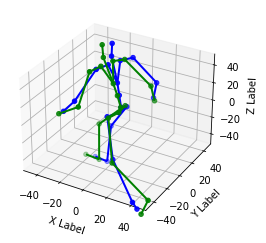

Epoch :  78
Batch : 0, Discriminator loss: 0.05364815145730972, Generator loss : 381.35323846969436
Batch : 10, Discriminator loss: 0.10712400078773499, Generator loss : 264.88446513677934
Batch : 20, Discriminator loss: 0.0908178985118866, Generator loss : 318.8704686178647
Epoch 78 complete, Train cumulated Discriminator loss : 1.845454216003418, Train cumulated Generator loss : 6621.9521660098435
Test Discriminator loss : 0.046896278858184814, Test Generator loss : 732.6178067879318
67 8


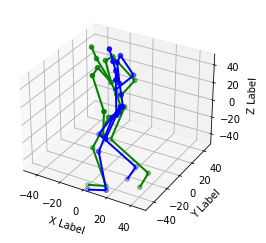

Epoch :  79
Batch : 0, Discriminator loss: 0.032248180359601974, Generator loss : 254.98466540912932
Batch : 10, Discriminator loss: 0.03565765544772148, Generator loss : 269.14200620098353
Batch : 20, Discriminator loss: 0.03374839946627617, Generator loss : 307.60776042284203
Epoch 79 complete, Train cumulated Discriminator loss : 1.4154469966888428, Train cumulated Generator loss : 6627.30861587032
Test Discriminator loss : 0.07101636379957199, Test Generator loss : 793.898797530205
90 2


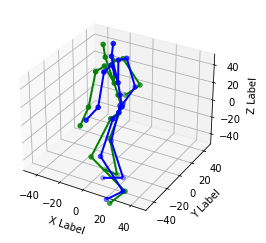

In [20]:
t = time.localtime()
log_dir = './runs/AE/simple_retarg/GAN_time_{}/'.format(time.strftime("%H_%M-%d_%M_%Y", t))
writer = SummaryWriter(log_dir)
text =  """
        parameters: 
        epochs:{}, learning_rate:{}, learning rate decay:{}, 
        learning rate frequency:{}, betas:{}, batch_size:{},  
        mult_ee={}, mult_adv={}, mult_glob={}, mult_velo={},
        isNormalize={}, normalize_velo={}, discrim_epoch={}, dropout={},
        """.format(epochs,learning_rate, lr_decay, lr_freq, betas, batch_size, mult_ee, mult_adv, mult_glob, mult_chain_velo,
                  isNormalize, normalize_velo, discrim_epoch, dropout)
writer.add_text('Hyperparameters',text)

%matploplib inline

D_cumul = 0
G_cumul = 0

G_loss_adv_cumul  = 0
G_loss_ee_cumul   = 0
G_loss_velo_cumul = 0
G_loss_glob_cumul = 0

for ep in range(epochs):
    print('Epoch : ', ep)
    for i, motion in enumerate(train_input_dataloader):
        
        # reshape motion to [batch_size, window_size, n_joints*channel_size]
        motion = motion.reshape(motion.shape[0], motion.shape[-2], motion.shape[-1]).float()
        curr_batch_size = motion.shape[0]

        # get a frame from the "real" data 
        randinds = np.random.randint(20,700, curr_batch_size)
        real_data = adv_dataset[randinds]

        offsets_sim = skdata_sim.offsets.reshape(1, 1, skdata_sim.offsets.shape[0], skdata_sim.offsets.shape[1])
        offsets_sim = offsets_sim.repeat(curr_batch_size, options['window_size'], 1, 1)

        offsets_data = skdata_data.offsets.reshape(1, 1, skdata_data.offsets.shape[0], skdata_data.offsets.shape[1])
        offsets_data = offsets_data.repeat(curr_batch_size, options['window_size'], 1, 1)

        #----------------------------------------------------
        # GENERATE AUTO ENCODED POSE
        #----------------------------------------------------

        # first get the offsets from the static encoder 
        # deep_offsets = static_encoder(torch.tensor(anim.offsets[np.newaxis, :,:]).float())
        deep_offsets_sim = static_encoder_sim(skdata_sim.offsets.reshape(1, skdata_sim.offsets.shape[0], -1))
        deep_offsets_data = static_encoder_data(skdata_data.offsets.reshape(1, skdata_data.offsets.shape[0], -1))

        latent = encoder_sim(motion, deep_offsets_sim)
        res = decoder_data(latent, deep_offsets_data)
        # latent, res = auto_encoder(motion, deep_offsets)
        
        # denormalize data to get correct forward kinematics 
        if isNormalize is True:
            res = adv_dataset.denormalize(res)
            real_data = adv_dataset.denormalize(real_data)
            motion = train_input_dataset.denormalize(motion)
    
        # transform res shape from [batch_size, (rotations+glob_pos+1), window_size]
        # to [batch_size, window_size, n_joints,4]
        res = res.permute(0,2,1).reshape(curr_batch_size, options['window_size'], -1, options['channel_base'])
        motion = motion.permute(0,2,1).reshape(curr_batch_size, options['window_size'], -1, options['channel_base'])
        real_data = real_data.permute(0,2,1).reshape(curr_batch_size, options['window_size'], -1, options['channel_base'])
        
        # extract rotation and velocity information from the concatenated data
        res_rotation = res[:,:,:-1,:]
        input_rotation = motion[:,:,:-1,:]
        res_glob_velo  = res[:,:,-1:,:-1]
        input_glob_velo  = motion[:,:,-1:,:-1]
        real_rotation = real_data[:,:,:-1,:]
        real_glob_velo  = real_data[:,:,-1:,:-1]
        
        # the current output rotation is not necessarily a normalized quaternion
        res_rotation = torch.nn.functional.normalize(res_rotation, dim=3)
        
        res_glob = res_rotation[:,:,0,:].reshape(curr_batch_size, options['window_size'], -1)
        input_glob = input_rotation[:,:,0,:].reshape(curr_batch_size, options['window_size'], -1)
        real_glob = real_rotation[:,:,0,:].reshape(curr_batch_size, options['window_size'], -1)

        # apply fk on generated pos, this will be the 'fake' data in the discriminator
        _, input_pos = lafan_utils.quat_fk(input_rotation, offsets_sim, skdata_sim.parents)
        _, fake_pos = lafan_utils.quat_fk(res_rotation, offsets_data, skdata_data.parents)
        _, real_pos = lafan_utils.quat_fk(real_rotation, offsets_data, skdata_data.parents)
        

        # local positions used for ee loss by setting the first rotation as an 
        # identity quaternion
        input_rotation_local = torch.clone(input_rotation)
        res_rotation_local = torch.clone(res_rotation)

        input_rotation_local[:,:,0,:] = torch.tensor([1,0,0,0]).float() 
        res_rotation_local[:,:,0,:] = torch.tensor([1,0,0,0]).float() 
        _, input_pos_local = lafan_utils.quat_fk(input_rotation_local, offsets_sim, skdata_sim.parents)
        _, fake_pos_local = lafan_utils.quat_fk(res_rotation_local, offsets_data, skdata_data.parents)

        # the GAN update code is mostly taken from :
        #https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#loss-functions-and-optimizers
        

        # UPDATE DISCRIMINATOR :
        # first do real data batch then fake data
        
        # start adverserial training after a set number of epochs
        if ep >= discrim_epoch:
            loss_real, loss_fake, loss_discrim = discriminator.D_loss(real_pos, fake_pos, False)
            discrim_optimizer.step()
        
        # UPDATE GENERATOR NETWORK
        # auto_encoder.zero_grad()
        encoder_sim.zero_grad()
        decoder_data.zero_grad()
        static_encoder_sim.zero_grad()
        static_encoder_data.zero_grad()
        
        # Adversial Loss 
        loss_adv = 0
        if ep >= discrim_epoch:
            # use real labels to maximize log(D(G(x))) instead of log(1-D(G(x)))
            label = torch.full((curr_batch_size,), real_label, dtype=torch.float, device=device)
            label.fill_(real_label)
            # use updated discriminator
            output = discriminator(fake_pos.float()).view(-1)
            # Calculate the generator's loss and gradients
            loss_adv = criterion_gan(output,label)
            
        # Gobal, Velocity and End Effector Losses
        loss_glob = criterion_glob(res_glob, input_glob)
        # Get the loss that tries to match the total velocity of every corresponding chain        
        input_vel, fake_vel = lafan_utils.get_batch_velo(input_pos, fake_pos, skdata_sim.frametime)
        # loss_chain_velo = calc_chain_velo_loss(real_vel, fake_vel, chain_indices, 
        #                                        criterion_velo, normalize_velo = False)
        loss_chain_velo = criterion_velo(res_glob_velo/skdata_data.height, input_glob_velo/skdata_sim.height)
        loss_ee = calc_ee_loss(input_vel, input_pos_local, fake_vel, fake_pos_local,
                               criterion_ee, skdata_sim, skdata_data)
        

        # combine all the losses together
        loss_gen =  loss_adv*mult_adv + loss_ee*mult_ee + \
        loss_glob*mult_glob + loss_chain_velo*mult_chain_velo
        
        # update gradient
        loss_gen.backward()
        gen_optimizer.step()
        
        # record losses 
        D_cumul += loss_discrim
        G_cumul += loss_gen
        
        G_loss_adv_cumul += loss_adv
        G_loss_ee_cumul  += loss_ee
        G_loss_velo_cumul+= loss_chain_velo
        G_loss_glob_cumul+= loss_glob

        if(i % 10 == 0):
            print("Batch : {}, Discriminator loss: {}, Generator loss : {}".format(i, loss_discrim, loss_gen))
    
    scheduler.step()

    N = 700-20#len(train_input_dataset)

    writer.add_scalar('Train/D_loss', D_cumul/N, ep)
    writer.add_scalar('Train/G_loss', G_cumul/N, ep)
    writer.add_scalar('Train/adv_loss', G_loss_adv_cumul/N *mult_adv , ep)
    writer.add_scalar('Train/ee_loss',  G_loss_ee_cumul/N  *mult_ee, ep)
    writer.add_scalar('Train/velo_loss',G_loss_velo_cumul/N*mult_chain_velo, ep)
    writer.add_scalar('Train/glob_loss',G_loss_glob_cumul/N*mult_glob, ep)
    
    writer.add_scalar('Hyperparameter/learning_rate', scheduler.get_last_lr()[0], ep)

    print("Epoch {} complete, Train cumulated Discriminator loss : {}, Train cumulated Generator loss : {}".format(ep, D_cumul, G_cumul) )
    
    D_cumul = 0
    G_cumul = 0
    
    G_loss_adv_cumul  = 0
    G_loss_ee_cumul   = 0
    G_loss_velo_cumul = 0
    G_loss_glob_cumul = 0
    
    #----------------------------------------------------------------------
    # TEST
    #----------------------------------------------------------------------
    with torch.no_grad():
        
        # TEST ON A RANDOM FRAME
        rand_index = np.random.randint(700,800, 100)
        curr_batch_size = 100
        test_data = train_input_dataset[rand_index].float()

        # get a frame from the "real" data 
        randinds = np.random.randint(20,700, curr_batch_size)
        real_data = adv_dataset[randinds]
        
        motion = test_data        
        offsets_sim = skdata_sim.offsets.reshape(1, 1, skdata_sim.offsets.shape[0], skdata_sim.offsets.shape[1])
        offsets_sim = offsets_sim.repeat(curr_batch_size, options['window_size'], 1, 1)

        offsets_data = skdata_data.offsets.reshape(1, 1, skdata_data.offsets.shape[0], skdata_data.offsets.shape[1])
        offsets_data = offsets_data.repeat(curr_batch_size, options['window_size'], 1, 1)
    
        # first get the offsets from the static encoder 
        # deep_offsets = static_encoder(torch.tensor(anim.offsets[np.newaxis, :,:]).float())
        deep_offsets_sim = static_encoder_sim(skdata_sim.offsets.reshape(1, skdata_sim.offsets.shape[0], -1))
        deep_offsets_data = static_encoder_data(skdata_data.offsets.reshape(1, skdata_data.offsets.shape[0], -1))

        latent = encoder_sim(motion, deep_offsets_sim)
        res = decoder_data(latent, deep_offsets_data)
        # latent, res = auto_encoder(motion, deep_offsets)
        
        # denormalize data to get correct forward kinematics 
        if isNormalize is True:
            res = adv_dataset.denormalize(res)
            real_data = adv_dataset.denormalize(real_data)
            motion = train_input_dataset.denormalize(motion)
    

        # transform res shape from [batch_size, (rotations+glob_pos+1), window_size]
        # to [batch_size, window_size, n_joints,4]
        res = res.permute(0,2,1).reshape(curr_batch_size, options['window_size'], -1, options['channel_base'])
        motion = motion.permute(0,2,1).reshape(curr_batch_size, options['window_size'], -1, options['channel_base'])
        real_data = real_data.permute(0,2,1).reshape(curr_batch_size, options['window_size'], -1, options['channel_base'])
        
        # extract rotation and velocity information from the concatenated data
        res_rotation = res[:,:,:-1,:]
        input_rotation = motion[:,:,:-1,:]
        res_glob_velo  = res[:,:,-1:,:-1]
        input_glob_velo  = motion[:,:,-1:,:-1]
        real_rotation = real_data[:,:,:-1,:]
        real_glob_velo  = real_data[:,:,-1:,:-1]
        
        # the current output rotation is not necessarily a normalized quaternion
        res_rotation = torch.nn.functional.normalize(res_rotation, dim=3)
        
        res_glob = res_rotation[:,:,0,:].reshape(curr_batch_size, options['window_size'], -1)
        input_glob = input_rotation[:,:,0,:].reshape(curr_batch_size, options['window_size'], -1)
        real_glob = real_rotation[:,:,0,:].reshape(curr_batch_size, options['window_size'], -1)

        # apply fk on generated pos, this will be the 'fake' data in the discriminator
        _, input_pos = lafan_utils.quat_fk(input_rotation, offsets_sim, skdata_sim.parents)
        _, fake_pos = lafan_utils.quat_fk(res_rotation, offsets_data, skdata_data.parents)
        _, real_pos = lafan_utils.quat_fk(real_rotation, offsets_data, skdata_data.parents)
        
        # local positions used for ee loss by setting the first rotation as an 
        # identity quaternion
        input_rotation_local = torch.clone(input_rotation)
        res_rotation_local = torch.clone(res_rotation)

        input_rotation_local[:,:,0,:] = torch.tensor([1,0,0,0]).float() 
        res_rotation_local[:,:,0,:] = torch.tensor([1,0,0,0]).float() 
        _, input_pos_local = lafan_utils.quat_fk(input_rotation_local, offsets_sim, skdata_sim.parents)
        _, fake_pos_local = lafan_utils.quat_fk(res_rotation_local, offsets_data, skdata_data.parents)

        
        #-----------------
        # GET DISCRIM LOSS
        #-----------------    
        loss_real, loss_fake, loss_discrim = discriminator.D_loss(real_pos, fake_pos, True)
                
        #-----------------
        # GET GEN LOSS
        #-----------------
        # use real labels to maximize log(D(G(x))) instead of log(1-D(G(x)))
        label = torch.full((curr_batch_size,), real_label, dtype=torch.float, device=device)
        label.fill_(real_label)
        # use updated discriminator
        output = discriminator(fake_pos.float()).view(-1)

        # Calculate the generator's loss and gradients
        loss_adv = criterion_gan(output,label)
        loss_glob = criterion_glob(res_glob, input_glob)

        input_vel, fake_vel = lafan_utils.get_batch_velo(input_pos, fake_pos, skdata_sim.frametime)
        # loss_chain_velo = calc_chain_velo_loss(real_vel, fake_vel, chain_indices, 
        #                                        criterion_velo, normalize_velo = False)
        loss_chain_velo = criterion_velo(res_glob_velo/skdata_data.height, input_glob_velo/skdata_sim.height)
        loss_ee = calc_ee_loss(input_vel, input_pos_local, fake_vel, fake_pos_local,
                               criterion_ee, skdata_sim, skdata_data)
        
        # combine all the losses together
        loss_gen =  loss_adv*mult_adv + loss_ee*mult_ee + \
        loss_glob*mult_glob + loss_chain_velo*mult_chain_velo
        

        N = 100
        writer.add_scalar('Test/D_loss', loss_discrim/N, ep)
        writer.add_scalar('Test/G_loss', loss_gen/N, ep)
        writer.add_scalar('Test/adv_loss', loss_adv/N       *mult_adv , ep)
        writer.add_scalar('Test/ee_loss',  loss_ee/N        *mult_ee , ep)
        writer.add_scalar('Test/velo_loss',loss_chain_velo/N*mult_chain_velo, ep)
        writer.add_scalar('Test/glob_loss',loss_glob/N      *mult_glob, ep)
        
        # print one
        batch_ind = np.random.randint(0,len(rand_index))
        frame_ind = np.random.randint(0,options['window_size'])

        print("Test Discriminator loss : {}, Test Generator loss : {}".format(loss_discrim, loss_gen) )
        print(batch_ind, frame_ind)
        
        # input_pos[batch_ind,frame_ind,:,2] = -input_pos[batch_ind,frame_ind,:,2] 
        two_skeleton_plot(fake_pos[batch_ind,frame_ind,:,:].cpu().detach(),
                          input_pos[batch_ind,frame_ind,:,:].cpu().detach(),
                          skdata_data.edges, skdata_sim.edges,
                          'b','g', limits=limits)

writer.close()

In [31]:

from IPython.display import HTML
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib qt
# from matplotlib import rc

In [26]:

_, global_fake_pos = lafan_utils.get_global_position_from_velocity(torch.tensor([0,0,0]), 
                                                                   res_glob_velo[1], skdata_data.frametime,
                                                                   fake_pos[1])
_, global_input_pos = lafan_utils.get_global_position_from_velocity(torch.tensor([0,0,0]), 
                                                                   input_glob_velo[1], skdata_data.frametime, 
                                                                   input_pos[1])

c:\users\nicol\work\master\dissertation\ml-agents\ml-agents\mlagents\plugins\bvh_utils\visualize.py:104: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)


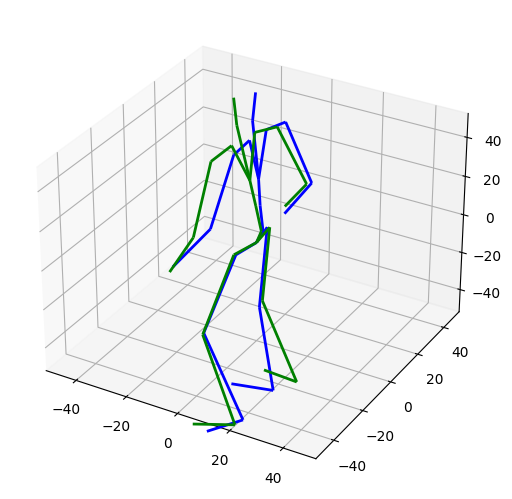

In [32]:
# global_real_pos = np.load('real_pos.npy')
# global_fake_pos = np.load('fake_pos.npy')
# global_real_pos = torch.tensor(global_real_pos)
# global_fake_pos = torch.tensor(global_fake_pos)

anim = motion_animation(global_input_pos.cpu().detach(), global_fake_pos.cpu().detach(), skdata_sim.edges, skdata_data.edges, limits)
# Set up formatting for the movie files
anim.save("subj2_to_subj1.gif", writer=PillowWriter(fps=30))

HTML(anim.to_jshtml())
# plt.show()
# %matploplib inline

In [20]:
np.save('real_pos.npy', real_pos.cpu().detach())
np.save('fake_pos.npy', fake_pos.cpu().detach())